In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sb
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner

## Read in data

In [2]:
with open('../lensed_SN_catalog/Baselinev3_0_doubles.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_quads.pkl', 'rb') as f:
    quads = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_unlensed.pkl', 'rb') as f:
    sne = pickle.load(f)
    
print("Doubles: ", len(doubles))
print("Quads: ", len(quads))
print("Unlensed: ", len(sne))

Doubles:  5000
Quads:  5000
Unlensed:  5000


In [3]:
df_ = pd.read_csv('../lensed_SN_catalog/processed_lcs_ana.csv')
mask_microdet_ = (df_.mult_method_micro==1)|np.isnan(df_.mult_method_micro)|(df_.mag_method_micro==1)|np.isnan(df_.mag_method_micro)

df_out_nim2     = df_[(df_.nima==2.0)]                             # Doubles
df_out_nim4     = df_[(df_.nima==4.0)]                             # Quads
df_out_unlensed = df_[(df_['type']=='unlensed')&(df_.nima==1.0)]   # Unlensed
df_out_lensed   = df_[(df_['type']!='unlensed')]                   # All lenses

mask_microdet = (df_out_lensed.mult_method_micro==1)|(df_out_lensed.mag_method_micro==1)  # Mask for detected with microlensing

plots_path = '../results/figures/'

df_out_nim2.keys()

Index(['g_npoints', 'g_rise_time', 'g_rise_rate', 'g_decay_time',
       'g_decay_rate', 'g_peak_mag', 'g_peak_mag_minus7', 'g_peak_mag_plus7',
       'g_peak_mag_minus14', 'g_peak_mag_plus14',
       ...
       'y_peak_mag_plus14_err_micro_abs_zs',
       'y_peak_mag_plus14_err_micro_abs_zl', 'z_lens', 'ima',
       'mult_method_peak', 'mult_method', 'mult_method_micro',
       'mag_method_peak', 'mag_method', 'mag_method_micro'],
      dtype='object', length=562)

## Compute detected sample

In [4]:
dt_doubles, dt_quads = [], []
mutot_doubles, mutot_quads = [], []
peak_i_doubles, peak_i_quads = [], []
peak_r_doubles, peak_r_quads = [], []
peak_z_doubles, peak_z_quads = [], []
peak_y_doubles, peak_y_quads = [], []

for s in range(len(doubles)):
    
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    peak_r_doubles.append(doubles['peak_magnitudes_micro'][s][1])
    peak_r_quads.append(quads['peak_magnitudes_micro'][s][1])
    peak_i_doubles.append(doubles['peak_magnitudes_micro'][s][2])
    peak_i_quads.append(quads['peak_magnitudes_micro'][s][2])
    peak_z_doubles.append(doubles['peak_magnitudes_micro'][s][3])
    peak_z_quads.append(quads['peak_magnitudes_micro'][s][3])
    peak_y_doubles.append(doubles['peak_magnitudes_micro'][s][4])
    peak_y_quads.append(quads['peak_magnitudes_micro'][s][4])
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
peak_r_doubles = np.array(peak_r_doubles)
peak_r_quads = np.array(peak_r_quads)
peak_i_doubles = np.array(peak_i_doubles)
peak_i_quads = np.array(peak_i_quads)
peak_z_doubles = np.array(peak_z_doubles)
peak_z_quads = np.array(peak_z_quads)
peak_y_doubles = np.array(peak_y_doubles)
peak_y_quads = np.array(peak_y_quads)

In [6]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_detected_micro = (doubles['mag_method_micro'] == True) | (doubles['mult_method_micro'] == True)
md_detected_peak = (doubles['mag_method_peak'] == True) | (doubles['mult_method_peak'] == True)
md_nondetect_micro = (doubles['mag_method_micro'] == False) & (doubles['mult_method_micro'] == False)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected_micro = (quads['mag_method_micro'] == True) | (quads['mult_method_micro'] == True)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect_micro = (quads['mag_method_micro'] == False) & (quads['mult_method_micro'] == False)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)
mq_detected_peak = (quads['mag_method_peak'] == True) | (quads['mult_method_peak'] == True)

md_detected_micro_mag = (doubles['mag_method_micro'] == True)
md_detected_micro_mult = (doubles['mult_method_micro'] == True)
mq_detected_micro_mag = (quads['mag_method_micro'] == True)
mq_detected_micro_mult = (quads['mult_method_micro'] == True)

md_mult_peak = (doubles['mult_method_peak'] == True)
md_mag_peak = (doubles['mag_method_peak'] == True)
mq_mult_peak = (quads['mult_method_peak'] == True)
mq_mag_peak = (quads['mag_method_peak'] == True)

# Minimum time delay
dt_lim = 10
md_dt_lim = dt_doubles > dt_lim
mq_dt_lim = dt_quads > dt_lim

md_thetaE = doubles['theta_E'] > 0.5
mq_thetaE = quads['theta_E'] > 0.5

print("Doubles detected: ", md_detected_micro.sum())
print("Quads detected: ", mq_detected_micro.sum())

Doubles detected:  2057
Quads detected:  3462


In [12]:
mlim = 25
filters = ['g', 'r', 'i', 'z', 'y']
dt_doubles, dt_quads = [], []
Nobs_doubles, Nobs_quads = [], []
duration_doubles, duration_quads = [], []
mutot_doubles, mutot_quads = [], []
m_peak_doubles, m_peak_quads = [], []
md_3det2band, mq_3det2band = [], []
md_5det2band, mq_5det2band = [], []

for s in range(len(doubles)):
    
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    
    #if len(doubles[])
    
    try:
        Nobs_doubles.append(len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > 5]))
        Nobs_quads.append(len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > 5]))
    except:
        print("nan added to Nobs")
        Nobs_doubles.append(np.nan)
        Nobs_quads.append(np.nan)
        
    duration_doubles.append(doubles['obs_end'][s] - doubles['obs_start'][s])
    duration_quads.append(quads['obs_end'][s] - quads['obs_start'][s])
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    m_peak_doubles.append(np.nanmin(doubles['obs_mag_unresolved'][s]))
    m_peak_quads.append(np.nanmin(quads['obs_mag_unresolved'][s]))
    
    # Check detection criteria
    if len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > 5]) >= 3:
        filters5sig = doubles['obs_bands'][s][doubles['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            md_3det2band.append(True)
        else:
            md_3det2band.append(False)
    else:
        md_3det2band.append(False)
        
    if len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > 5]) >= 3:
        filters5sig = quads['obs_bands'][s][quads['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            mq_3det2band.append(True)
        else:
            mq_3det2band.append(False)
    else:
        mq_3det2band.append(False)
        
    # Check detection criteria
    if len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > 5]) >= 5:
        filters5sig = doubles['obs_bands'][s][doubles['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            md_5det2band.append(True)
        else:
            md_5det2band.append(False)
    else:
        md_5det2band.append(False)
        
    if len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > 5]) >= 5:
        filters5sig = quads['obs_bands'][s][quads['snr_unresolved'][s] > 5]
        if len(np.intersect1d(filters, filters5sig)) >= 2:
            mq_5det2band.append(True)
        else:
            mq_5det2band.append(False)
    else:
        mq_5det2band.append(False)
    
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
Nobs_doubles = np.array(Nobs_doubles)
Nobs_quads = np.array(Nobs_quads)
duration_doubles = np.array(duration_doubles)
duration_quads = np.array(duration_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
m_peak_doubles = np.array(m_peak_doubles)
m_peak_quads = np.array(m_peak_quads)
md_3det2band = np.array(md_3det2band)
mq_3det2band = np.array(mq_3det2band)
md_5det2band = np.array(md_5det2band)
mq_5det2band = np.array(mq_5det2band)

## Impact of rolling cadence

In [8]:
def N_glsne(Nobs_lim, cadence, configuration):
    # Calculate the yearly number of detected lensed SNe with N_obs number of observations.
    
    snr_lim = 5
    Nobs_doubles, Nobs_quads = [], []

    for s in range(len(doubles)):
        Nobs_doubles.append(len(doubles['snr_unresolved'][s][doubles['snr_unresolved'][s] > snr_lim]))
        try:
            Nobs_quads.append(len(quads['snr_unresolved'][s][quads['snr_unresolved'][s] > snr_lim]))
        except:
            Nobs_quads.append(np.nan)

    Nobs_doubles = np.array(Nobs_doubles)
    Nobs_quads = np.array(Nobs_quads)
    
    if cadence == 'nonrol' and configuration == 'doubles':
        number = ((md_WFD) & (md_detected_micro) & (md_nonrol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    elif cadence == 'rol' and configuration == 'doubles':
        number = ((md_WFD) & (md_detected_micro) & (md_rol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    elif cadence == 'nonrol' and configuration == 'quads':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (Nobs_quads > Nobs_lim)).sum()*sq2
    elif cadence == 'rol' and configuration == 'quads':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (Nobs_quads > Nobs_lim)).sum()*sq2
    elif cadence == 'nonrol' and configuration == 'all':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (Nobs_quads > Nobs_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    elif cadence == 'rol' and configuration == 'all':
        number = ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (Nobs_quads > Nobs_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (Nobs_doubles > Nobs_lim)).sum()*sd2
    
    #elif cadence == 'rol' and configuration == 'all' and rolling == 'active':
    #    number = ((mq_detected) & (mq_rol) & (active_quads) & (Nobs_quads > Nobs_lim)).sum()*sq + ((md_detected) & (md_rol) & (active_doubles) & (Nobs_doubles > Nobs_lim)).sum()*sd 
    
    return number    
    

In [10]:
Nobs_range = np.linspace(1, 100, 100)
N_rol_all = []
N_nonrol_all = []

# Scale by yearly predicted rates by Wojtak et al.
rates_total = 89 * 3
fraction_quads = 0.28
fraction_doubles = 0.72
rates_quads = rates_total * fraction_quads
rates_doubles = rates_total * fraction_doubles

sd2 = rates_doubles / ((md_WFD) & (md_detected_peak)).sum() / 1.5 /20000 * 18000
sq2 = rates_quads / ((mq_WFD) & (mq_detected_peak)).sum() / 1.5 /20000 * 18000

for n in Nobs_range:
    N_rol_all.append(N_glsne(n, 'rol', 'all'))
    N_nonrol_all.append(N_glsne(n, 'nonrol', 'all'))
    
N_nonrol_all = np.array(N_nonrol_all)
N_rol_all = np.array(N_rol_all)

### Figure 6

Non-rol - mean Nobs:  14.953360768175584  median:  13.0
Rol -     mean Nobs:  16.60007683442182  median:  12.0


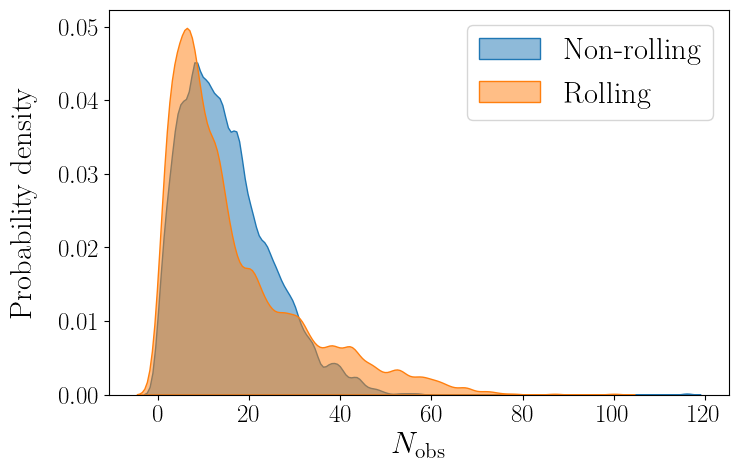

In [14]:
Nobs_nonrol = list(Nobs_doubles[(md_detected_micro) & (md_nonrol)]) + list(Nobs_quads[(mq_detected_micro) & (mq_nonrol)])
Nobs_rol = list(Nobs_doubles[(md_detected_micro) & (md_rol)]) + list(Nobs_quads[(mq_detected_micro) & (mq_rol)])

fig, ax = plt.subplots(1,1, figsize=(8, 5))
sb.kdeplot(Nobs_nonrol, ax=ax, fill=True, alpha=0.5, label="Non-rolling", bw_adjust=0.5)
sb.kdeplot(Nobs_rol, ax=ax, fill=True, alpha=0.5, label="Rolling", bw_adjust=0.5)
# plt.hist(Nobs_doubles[(md_detected) & (md_nonrol)], bins=40, alpha=0.5, density=True)
# plt.hist(Nobs_doubles[(md_detected) & (md_rol)], bins=40, alpha=0.5, density=True)
ax.set_xlabel(r"$N_{\rm{obs}}$", fontsize=22)
ax.set_ylabel(r"Probability density", fontsize=22, labelpad=15)
plt.legend(fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

print("Non-rol - mean Nobs: ", np.mean(Nobs_nonrol), " median: ", np.median(Nobs_nonrol))
print("Rol -     mean Nobs: ", np.mean(Nobs_rol), " median: ", np.median(Nobs_rol))

#plt.savefig("../Results/Figures/Cadence_Nobs_rolling_nonrolling.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

### Figure 7

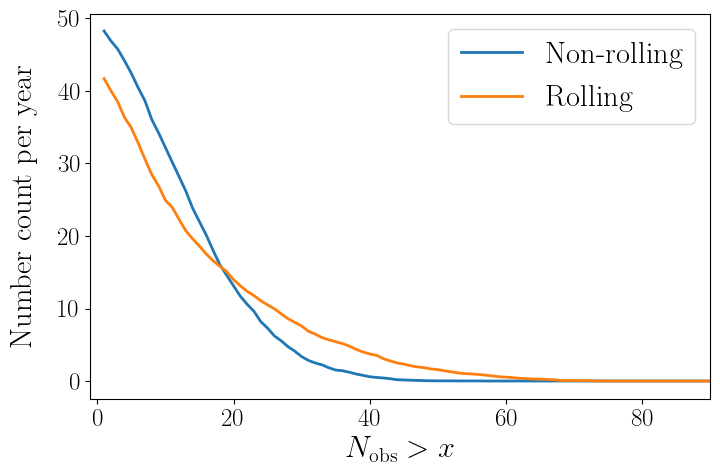

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(Nobs_range, N_nonrol_all, label="Non-rolling", lw=2)
plt.plot(Nobs_range, N_rol_all, label="Rolling", lw=2)

plt.xlabel(r"$N_{\Large \textrm{obs}} > x$", fontsize=22)
plt.ylabel(r"Number count per year", fontsize=22, labelpad=15)
plt.xlim(-1, 90)
plt.legend(fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
#plt.savefig("../Results/Figures/Cadence_Nglsne_Nobs_all.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
